In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import MetaTrainer, ParameterEstimationTrainer
from bayesflow.networks import SequenceNet, EvidentialNetwork, InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import MetaAmortizer, SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.diagnostics import true_vs_estimated

from generative_models import batch_generate_levy_lca, generate_levy_lca

from meta_aux_classes import *

%load_ext Cython
%load_ext wurlitzer

In [2]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

In [67]:
class LCAPrior:
    def __init__(self, n_conditions=2, n_accumulators=2):
        self.n_conditions = n_conditions
        self.n_accumulators = n_accumulators
    
    def __call__(self, batch_size):
        p = np.random.uniform(0.10, 2.00, size=(batch_size, self.n_conditions * self.n_accumulators)).astype('double')
        a = np.random.uniform(0.50, 2.00, size=batch_size).astype('double')
        beta = np.random.uniform(0.01, 0.99, size=batch_size).astype('double')
        kappa = np.random.uniform(0.01, 0.99, size=batch_size).astype('double')
        ndt = np.random.uniform(0.1, 0.4, size=batch_size).astype('double')
        # alpha = np.random.uniform(1.0, 2.0, size=batch_size).astype('double')
        
        params = np.column_stack((p, a, beta, kappa, ndt))
        return params
    

class LCASimulator:
    def __init__(self, n_conditions=2, n_accumulators=2):
        self.n_conditions = n_conditions
        self.n_accumulators = n_accumulators
    
    @staticmethod
    def partition(n, c):
        """Partitions the integer n into c equally sized chunks and returns an c-lengthed array of chunk sizes."""
        return [n // c + (1 if x < n % c else 0)
                      for x in range (c)]
        
    def __call__(self, params, n_obs):
        n_sim = params.shape[0]
        
        # total number of drift rates = n_cond * n_acc
        n_p = self.n_conditions * self.n_accumulators
        
        # Split n_obs equally between conditions 
        n_obs_cond = self.partition(n_obs, self.n_conditions)

        # Shared parameters
        a, beta, kappa, ndt = tuple(params.T[n_p:])
        alpha = np.full_like(a, 2.0, dtype='double')   # Levy alpha-stable parameter
        
        # Individual parameters per cond and accumulator: p, x_acc
        p_cond = params[:, :n_p].reshape((n_sim, self.n_accumulators, self.n_conditions))
        x_acc = np.zeros_like(p_cond, dtype='double')
        
        # initialize sim_data array
        sim_data = np.empty((n_sim, n_obs), dtype=np.float32)
        
        # indexing along n_obs dimension
        start_idx = end_idx = 0
        for c in range(self.n_conditions):
            start_idx, end_idx = end_idx, end_idx + n_obs_cond[c]  # increment by current n_obs_cond
            cond_data = batch_generate_levy_lca(n_obs_cond[c], 
                                                p_cond[:, :, c], x_acc[:, :, c],  # individual 
                                                kappa, beta, a, ndt, alpha)       # shared
            sim_data[:, start_idx:end_idx] = np.array(cond_data, dtype=np.float32)
        
        cond_row = np.concatenate([n_obs_cond[c] * [c] for c in range(self.n_conditions)])
        cond_arr = np.stack(n_sim * [cond_row])
        sim_data = np.stack((sim_data, cond_arr), axis=-1)
        
        return sim_data

In [68]:
# levy_lca_simulator() debugger
prior = LCAPrior(n_conditions=2, n_accumulators=2)
simulator = LCASimulator(n_conditions=2, n_accumulators=2)
p = prior(6)
x = simulator(p, 10)
print(p[[0, 2,4]])
print(x[[0, 2,4]])
print(x.shape)

[[0.62382149 0.27310221 0.83930933 1.0324448  0.65544376 0.87402553
  0.8268101  0.25070774]
 [0.80190546 0.79737377 0.62357543 0.86314556 1.78361756 0.51159639
  0.33303089 0.13447779]
 [0.55408139 0.27420418 1.14963728 0.53707381 0.57657747 0.52052687
  0.38948898 0.22375745]]
[[[ 0.35370773  0.        ]
  [-0.40370774  0.        ]
  [ 0.35470775  0.        ]
  [-0.41770774  0.        ]
  [ 0.38470775  0.        ]
  [-0.66270775  1.        ]
  [ 0.63570774  1.        ]
  [ 0.45670775  1.        ]
  [ 0.94870776  1.        ]
  [ 0.60870773  1.        ]]

 [[ 2.10947776  0.        ]
  [ 0.3864778   0.        ]
  [-2.18047786  0.        ]
  [-1.22747779  0.        ]
  [ 1.68847775  0.        ]
  [ 0.52547777  1.        ]
  [-1.77247775  1.        ]
  [ 0.9994778   1.        ]
  [-3.10347772  1.        ]
  [-4.49947786  1.        ]]

 [[-0.33075744  0.        ]
  [ 0.36375746  0.        ]
  [ 0.63475746  0.        ]
  [ 0.28975746  0.        ]
  [ 0.29775745  0.        ]
  [ 0.40475744  

In [69]:
D = 8 # 

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    2,
    'dense_s1_args': {'activation': 'relu', 'units': 128},
    'dense_s2_args': {'activation': 'relu', 'units': 128},
    'dense_s3_args': {'activation': 'relu', 'units': 128},
}

summary_net = InvariantNetwork(summary_meta)  # Output size 128


inference_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork({'n_params': D})

amortizer = SingleModelAmortizer(inference_net, summary_net)

In [70]:
generative_model = GenerativeModel(prior=prior, simulator=simulator)

In [71]:
x[0].shape

(10, 2)

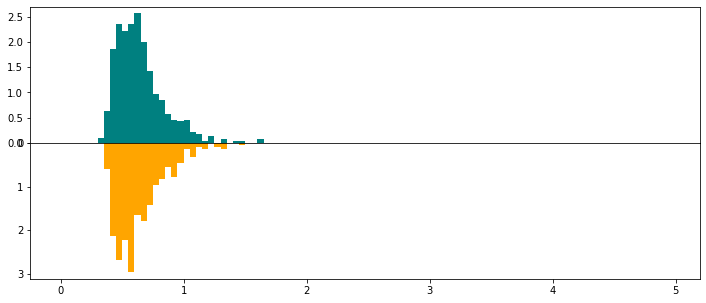

In [119]:
p, x = generative_model(1, 1000)
rt, cat = x[0].T[0], x[0].T[1]
pos_rt = rt[rt>0]
neg_rt = - rt[rt<0]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,5))
max_rt = np.max(rt)
bins = np.arange(0,5,0.05)

for ax, data, color, invert in zip(axes.ravel(), [pos_rt, neg_rt], ['teal', 'orange'],  [False,True]):
    ax.hist(data, bins=bins, color=color, density=True)
    
    if invert:
        ax.invert_yaxis()
        
plt.subplots_adjust(hspace=0)

/Users/marvin/opt/anaconda3/envs/bf/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marvin/opt/anaconda3/envs/bf/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


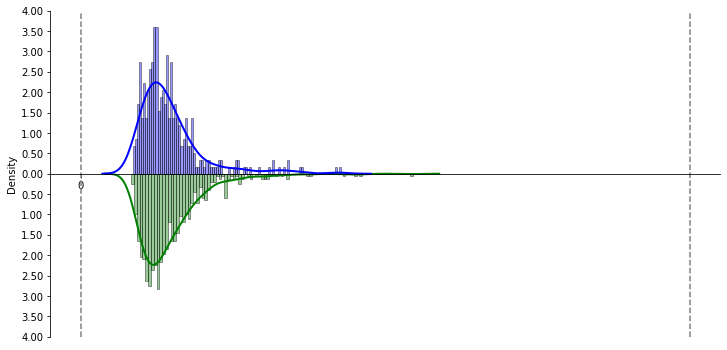

In [174]:
p, x = generative_model(1, 1000)
rt, cat = x[0].T[0], x[0].T[1]
pos_rt = rt[rt>0]
neg_rt = - rt[rt<0]

fig, ax = plt.subplots(figsize=(12, 6))

sns.distplot(pos_rt, hist=True, kde=True, hist_kws={'edgecolor': 'black'}, kde_kws={'linewidth': 2}, bins=100,
             color='green')
for p in ax.patches:  # turn the histogram upside down
    p.set_height(-p.get_height())
for l in ax.lines:  # turn the kde curve upside down
    l.set_ydata(-l.get_ydata())

sns.distplot(neg_rt, hist=True, kde=True, hist_kws={'edgecolor': 'black'}, kde_kws={'linewidth': 2}, bins=100,
             color='blue')
ax.set_xticks(np.arange(0, 5, 20))
#ax.set_yticks(np.arange(0.0, 5, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pos_ticks = np.array([t for t in ax.get_yticks() if t > 0])
ticks = np.concatenate([-pos_ticks[::-1], [0], pos_ticks])
ax.set_yticks(ticks)
ax.set_yticklabels([f'{abs(t):.2f}' for t in ticks])
ax.spines['bottom'].set_position('zero')

plt.axvline(0, color="grey", ls='--')
plt.axvline(5, color="grey", ls='--')

plt.show()

In [ ]:
trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      learning_rate=0.0001,
                     )

In [ ]:
losses = trainer.train_online(epochs=2, iterations_per_epoch=100, batch_size=16,
                                            n_obs=np.random.randint(100, 201))

In [ ]:
losses = trainer.train_rounds(epochs=2, rounds=2, sim_per_round=100, batch_size=32, 
                              n_obs=np.random.randint(100, 501))

In [ ]:
# Validate (quick and dirty)
p, x = trainer._forward_inference(100, 100)
param_samples = trainer.network.sample(x, n_samples=1000)
param_means = param_samples.mean(axis=0)
true_vs_estimated(p, param_means, ['p11', 'p12', 'p21', 'p22', 'a', 'beta', 'kappa', 'ndt'], figsize=(20,8))